In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, Input
import gurobipy as gp

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## problem 1

state: (s,t), where s is oil in ground and t is time

dynamics: 

          (s,t) -> (s,t+1) if no pumping

          (s,t) -> (0.8s,t+1) if normal pumping

          (s,t) -> (0.64s,t+1) if enhanced pumping

value function: v(s,t) = max sum all future discounted profits

bellman:

v(s,t) = max(0+$\delta$\*v(s,t+1), 10\*0.2\*s - 50k + $\delta$\*v(0.8s,t+1), 10\*0.36\*s - 120k + $\delta$\*v(0.64s,t+1)

Terminal: v(s,T) = 0
          

## problem 2

In [6]:
oil = pd.read_csv('./oil_produced.csv', index_col= 0)

In [7]:
oil.head()

,oil_produced
day,
1,491
2,464
3,490
4,512
5,497


In [8]:
ndays = oil.shape[0]
ndays

100

In [13]:
# decision variables: T, h1, h2, h3, ..., hn
obj = np.zeros(ndays+1)
obj[0] = 1000
obj[1:] = 1/ndays

A = np.zeros((ndays,ndays+1))
rhs = np.zeros(ndays)
dir = np.array(['>']*ndays)
vtype = ['I']+['C']*ndays

for day in range(ndays):
    A[day,0] = 2000
    A[day,day+1] = 1
    rhs[day] = 20*oil.oil_produced.loc[day+1]

In [15]:
spMod = gp.Model()
spMod_x = spMod.addMVar(len(obj),vtype=vtype) # tell the model how many variables there are
# must define the variables before adding constraints because variables go into the constraints
spMod_con = spMod.addMConstrs(A, spMod_x, dir, rhs) # NAME THE CONSTRAINTS!!! so we can get information about them later!
spMod.setMObjective(None,obj,0,sense=gp.GRB.MINIMIZE) # add the objective to the model...we'll talk about the None and the 0

spMod.Params.OutputFlag = 0 # tell gurobi to shut up!!
spMod.optimize()

Set parameter Username
Academic license - for non-commercial use only - expires 2022-08-25


In [16]:
# this is how many trucks to get...
spMod_x.x[0]

5.0

In [17]:
spMod.objval

5176.199999999996

In [18]:
# does the objval correspond to our definition of the cost of transporting the oil?
1000*spMod_x.x[0] + np.mean(20*np.maximum(oil.oil_produced - 100*spMod_x.x[0],0))

5176.2

## problem 3

In [20]:
def create_model(height,width,channels):
    # we cannot simply have 3 output nodes because we want to put a weight on each node's impact to the objective
    # that is different for each data point.  the only way to achieve this is to have 3 output layers, each having 1 node
    # the effect is the same, just the way TF/keras handles weights is different
    imp = Input(shape=(height,width,channels))
    mid = Conv2D(16,(8,8),strides=4,activation='relu')(imp)
    mid = Conv2D(32,(4,4),strides=2,activation='relu')(mid)
    mid = Flatten()(mid)
    mid = Dense(256,activation='relu')(mid)
    out0 = Dense(1,activation='linear',name='out0')(mid)
    out1 = Dense(1,activation='linear',name='out1')(mid)
    out2 = Dense(1,activation='linear',name='out2')(mid)
    out3 = Dense(1,activation='linear',name='out3')(mid)
    out4 = Dense(1,activation='linear',name='out4')(mid)
    out5 = Dense(1,activation='linear',name='out5')(mid)
    model = Model(imp,[out0,out1,out2,out3,out4,out5]) 
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),loss='mean_squared_error')
    
    return model

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 80, 80, 4)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 19, 19, 16)   4112        ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 8, 8, 32)     8224        ['conv2d[0][0]']                 
                                                                                                  
 flatten (Flatten)              (None, 2048)         0           ['conv2d_1[0][0]']               
                                                                                              

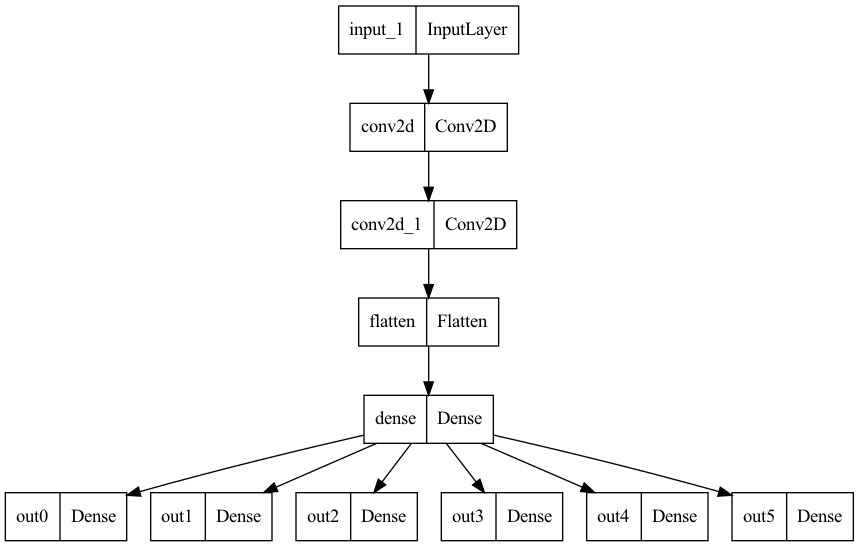

In [21]:
mod = create_model(80,80,4)
mod.summary()

tf.keras.utils.plot_model(mod)